In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from igraph import *

In [2]:
curr_dir = !pwd

significantly_similar_pairs = pd.read_csv(curr_dir[0]+"/sig_pairs_pval0.001_score11.csv", sep='\t', index_col=0)

In [3]:
#Create vertexes in igraph format
domains_list1 = significantly_similar_pairs["sim_dom1"].unique()
domains_list2 = significantly_similar_pairs["sim_dom2"].unique()
vertices_list = np.unique(np.concatenate((domains_list1, domains_list2), axis=0))

#Create edges in igraph format
edges_list = []
for index, row in significantly_similar_pairs.iterrows():
    sim_dom1 = row["sim_dom1"]
    sim_dom2 = row["sim_dom2"]
    edges_list.append((sim_dom1, sim_dom2))

In [4]:
len(vertices_list)

255

## Creating the graph

In [20]:
#Creating the graph
gr = Graph()
gr.add_vertices(vertices_list)
gr.add_edges(edges_list)
gr.es["scores"] = significantly_similar_pairs["scores"].tolist()
gr.es["pvals"] = significantly_similar_pairs["scores"].tolist()

In [32]:
#Normalize similarity scores to represent distance (lower = similar)
norm_scores = [x/(max(gr.es["scores"])+1) for x in gr.es["scores"]] #Adding 1 so that max similarity will be positive and not 0
gr.es["distances"] = [1-x for x in norm_scores]

### Visualizing connected components individually

In [7]:
#Connected components
x = gr.components()
y = x.subgraphs()

In [31]:
big_component = y[2]
print big_component.vcount()
print big_component.ecount()
print big_component.degree()
print big_component.density()

27
108
[14, 5, 21, 17, 11, 11, 4, 8, 6, 11, 8, 1, 8, 4, 3, 15, 3, 1, 13, 10, 7, 14, 2, 7, 9, 1, 2]
0.307692307692


In [36]:
l = [14, 5, 21, 17, 11, 11, 4, 8, 6, 11, 8, 1, 8, 4, 3, 15, 3, 1, 13, 10, 7, 14, 2, 7, 9, 1, 2]
l = np.array(l)

In [47]:
len(np.where(l > 8)[0])

11

In [32]:
big_component.vs["name"]

['AAA',
 'AAA_11',
 'AAA_18',
 'AAA_33',
 'AAA_5',
 'ABC_tran',
 'ADK',
 'Arf',
 'DEAD',
 'Dynamin_N',
 'G-alpha',
 'GBP',
 'GTP_EFTU',
 'Guanylate_kin',
 'Kinesin',
 'MMR_HSR1',
 'Microtub_bd',
 'Myosin_head',
 'NACHT',
 'Ras',
 'ResIII',
 'Roc',
 'SNF2_N',
 'SRPRB',
 'Septin',
 'Sulfotransfer_1',
 'Sulfotransfer_3']

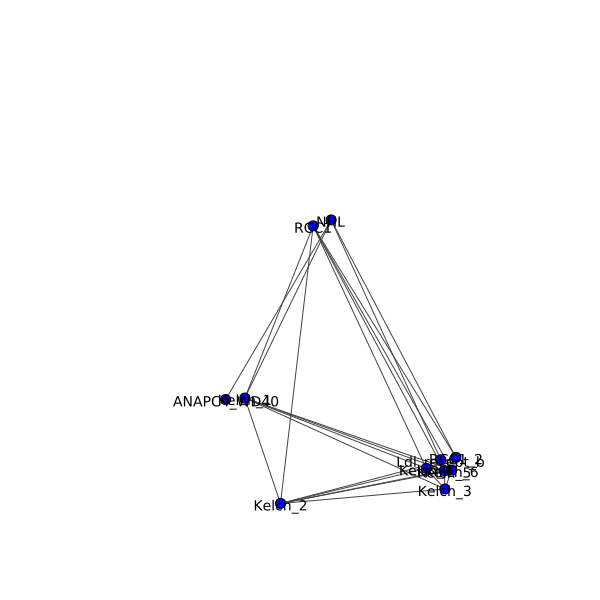

In [23]:
visual_style2 = {}
visual_style2["vertex_size"] = 10
visual_style2["layout"] = gr.layout("fr")
visual_style2["vertex_color"] = "blue"
#visual_style2["edge_width"] = [1 + 2 * int(is_high_score) for is_high_score in gr.es["is_sig"]]
visual_style2["vertex_label"] = big_component.vs["name"]
#plot(big_component, **visual_style2)
plot(big_component, "graphs/comp11_11graph.pdf", **visual_style2)

In [72]:
pvals = significantly_similar_pairs["p-values"].tolist()
pval_per = np.percentile(pvals, 80)
gr.es["is_sig"] = [True if x <= pval_per else False for x in pvals]

In [67]:
np.percentile(pvals, 99)

0.00098379999999999995

In [55]:
scores = significantly_similar_pairs["scores"].tolist()
scores_per = np.percentile(scores, 10)
gr.es["is_high_score"] = [True if x >= 20 else False for x in scores]

In [52]:
np.percentile(scores, 10)

18.076999999999998

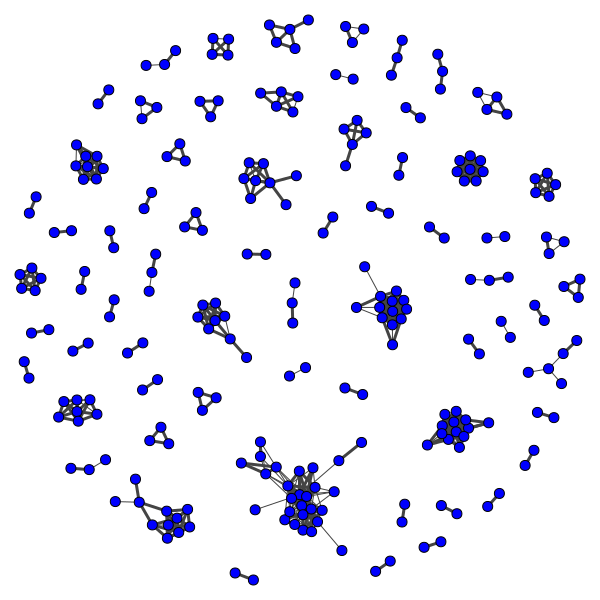

In [73]:
#Plotting the graph

visual_style = {}
visual_style["vertex_size"] = 10
visual_style["layout"] = gr.layout("fr")
visual_style["vertex_color"] = "blue"
visual_style["edge_width"] = [1 + 2 * int(is_sig) for is_sig in gr.es["is_sig"]]
#visual_style["vertex_label"] = gr.vs["name"]
plot(gr, **visual_style)
#plot(gr, "score10_graph.pdf", **visual_style)

### Create connected components groups

In [35]:
components = gr.components()
subgraphs = components.subgraphs()

In [80]:
similarity_clusters = defaultdict(dict)
domain_to_cluster = {}
for i in range(len(subgraphs)):
    cluster = subgraphs[i]
    
    #Assign all the domains in the cluster the number i
    for domain in cluster.vs["name"]:
        domain_to_cluster[domain] = i
    
    #Save cluster attributes
    similarity_clusters[i]["domains"] = cluster.vs["name"]
    similarity_clusters[i]["degrees"] = cluster.degree()
    highest_degree_idx = np.where(cluster.degree() == np.max(cluster.degree()))[0]
    similarity_clusters[i]["highest_degree"] = np.array(cluster.vs["name"])[highest_degree_idx].tolist()
    
    shortest_paths = cluster.shortest_paths_dijkstra(weights="distances", mode="ALL")
    shortest_path_avg = [np.mean(x) for x in shortest_paths]
    mediod_idx = np.where(shortest_path_avg == min(shortest_path_avg))[0]
    similarity_clusters[i]["mediode"] = np.array(cluster.vs["name"])[mediod_idx].tolist()

In [83]:
#Save dictionaries
with open(curr_dir[0]+"/sim_clusters/similarity_clusters_dict.pik", 'wb') as handle:
    pickle.dump(similarity_clusters, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(curr_dir[0]+"/sim_clusters/domain_to_cluster_dict.pik", 'wb') as handle:
    pickle.dump(domain_to_cluster, handle, protocol=pickle.HIGHEST_PROTOCOL)